In [1]:
import math
import torch
import gpytorch
import numpy as np
import numpy.linalg as linalg

import spectralgp

from spectralgp.samplers import AlternatingSampler
from spectralgp.models import ExactGPModel, SpectralModel, ProductKernelSpectralModel

from spectralgp.sampling_factories import ss_factory, ess_factory
from custom_plotting import plot_kernel, plot_subkernel, plot_subkernel_individual, plot_prior_kernel, plot_prior_subkernel_individual, plot_prior_subkernel

import data

import utils
import argparse

import sys
import matplotlib.pyplot as plt

import traceback

torch.set_default_dtype(torch.float64)

In [2]:
train_x, train_y, test_x, test_y, y_std, y_std_train, gen_kern = data.read_data('servo', nx=None, gen_pars=None,
                                                            linear_pars=None,
                                                            spacing='random',
                                                            noise=None)
in_dims = 1 if train_x.dim() == 1 else train_x.size(1)

use_cuda = torch.cuda.is_available()
print('Cuda is available', use_cuda)
if use_cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    train_x, train_y, test_x, test_y, y_std = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda(), y_std.cuda()
    if gen_kern is not None:
        gen_kern = gen_kern.cuda()

###########################################
## set up the spectral and latent models ##
###########################################
print("Input Dimensions {}".format(in_dims))



mlatent = 'shared'
shared = True if mlatent == 'shared' else False

Cuda is available True
Input Dimensions 4


In [3]:
data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
data_mod = spectralgp.models.ProductKernelSpectralModel(train_x, train_y, data_lh, shared=shared,
        normalize = False, symmetrize = False, num_locs = 100, spacing='random', pretrain=False, omega_max = 8., nonstat = True)

0
tensor(8.)
0
tensor(8.)
0
tensor(8.)


/home/jayson_s/projects/gpytorch/gpytorch/models/exact_gp.py:247: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


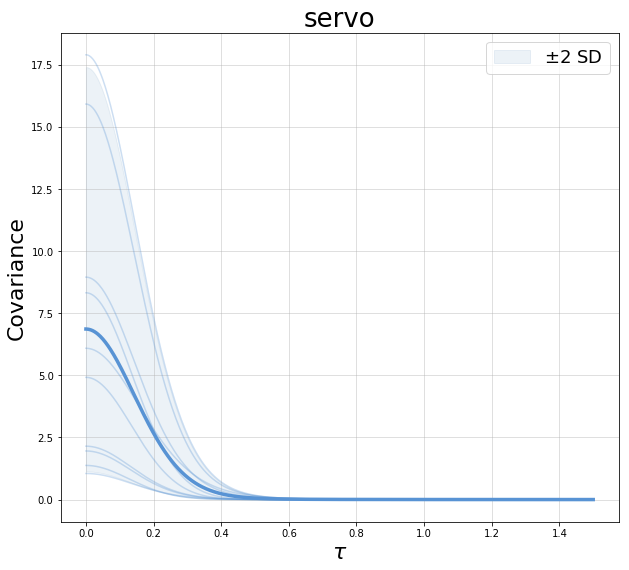

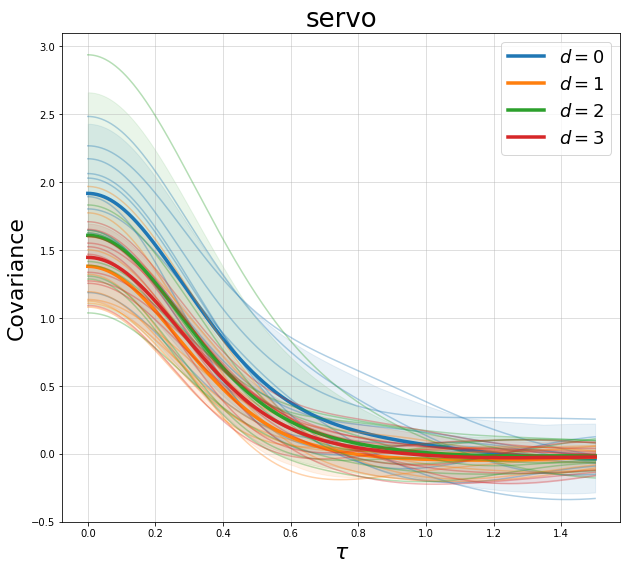

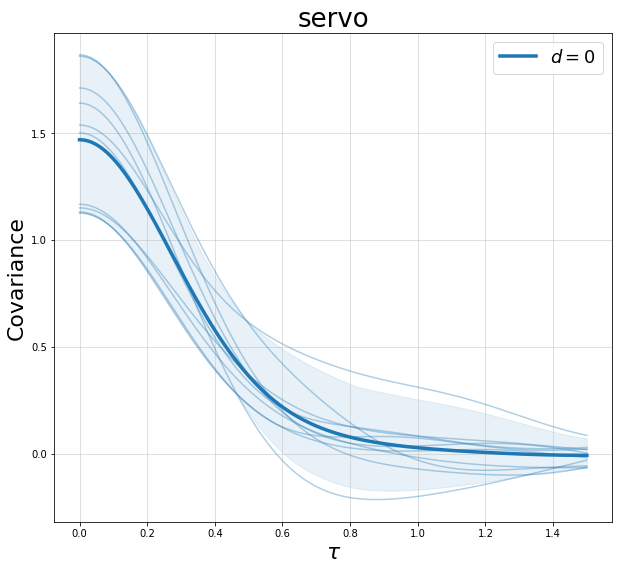

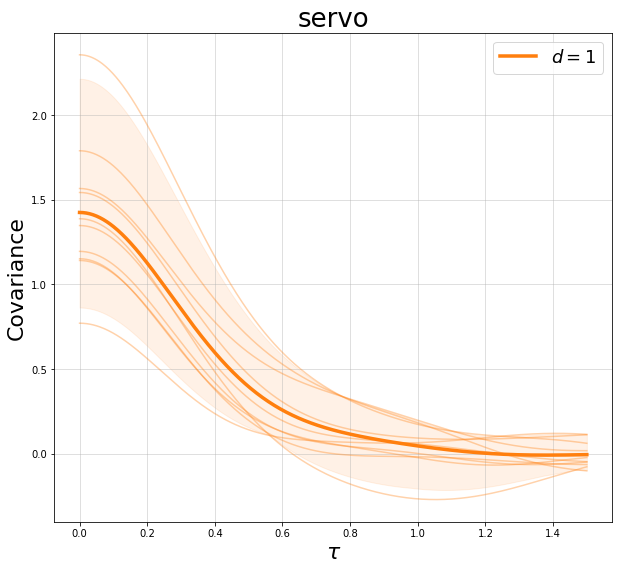

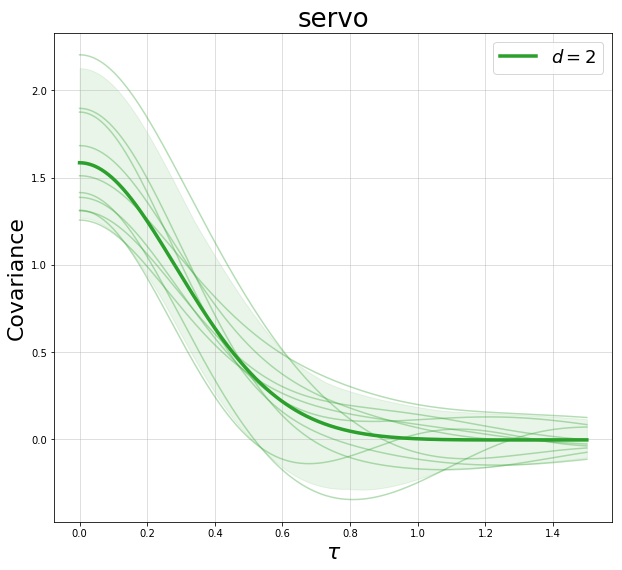

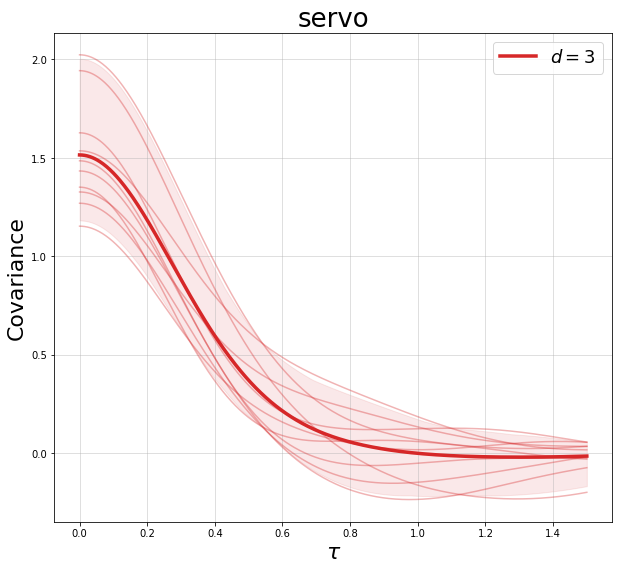

In [4]:
plot_prior_kernel(in_dims, data_mod, 'servo', mlatent)
plot_prior_subkernel(in_dims, data_mod, 'servo', mlatent)
plot_prior_subkernel_individual(in_dims, data_mod, 'servo', mlatent)

In [ ]:
alt_sampler = spectralgp.samplers.AlternatingSampler(
    [data_mod], [data_lh], 
    spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
    totalSamples=1, numInnerSamples=10, numOuterSamples=5, num_dims=in_dims
    )


alt_sampler.run()

Step:  0 Dimension:  0
Loss is:  tensor(-84.2944, grad_fn=<DivBackward0>)
Loss is:  tensor(-83.1229, grad_fn=<DivBackward0>)
Loss is:  tensor(-81.9962, grad_fn=<DivBackward0>)
Loss is:  tensor(-80.8534, grad_fn=<DivBackward0>)
Loss is:  tensor(-79.7536, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0
Step:  0 Dimension:  1
Loss is:  tensor(-79.2574, grad_fn=<DivBackward0>)
Loss is:  tensor(-78.1800, grad_fn=<DivBackward0>)
Loss is:  tensor(-77.1075, grad_fn=<DivBackward0>)
Loss is:  tensor(-76.0498, grad_fn=<DivBackward0>)
Loss is:  tensor(-75.0159, grad_fn=<DivBackward0>)
Task: 0 ; Iteration 0


In [ ]:
torch.equal(data_mod.covar_module.get_latent_params(1), data_mod.covar_module.get_latent_params(0))

In [ ]:
data_mod.eval()
data_lh.eval()

data_mod_means = torch.zeros_like(data_mod(test_x).mean)
total_variance = torch.zeros_like(data_lh(data_mod(test_x)).variance)

test_rmse = 0.0
unnorm_test_rmse = 0.0
nll_sum = 0.0
msll = 0.0

with torch.no_grad():
    marg_samples_num = min(len(alt_sampler.fhsampled[0][0]), alt_sampler.fgsampled[0].shape[-1])
    
    for x in range(0, marg_samples_num):
        # This line must come first
        data_mod.load_state_dict(alt_sampler.fhsampled[0][0][x]) # dim, ???, nsample
        
        for dim in range(0,in_dims):
            data_mod.covar_module.set_latent_params(alt_sampler.fgsampled[dim][0, :, x], idx=dim)
            
        # Verify this is the correct way to handle multidim train setting

        data_mod.set_train_data(train_x, train_y) # to clear out the cache
        data_mod_means += data_mod(test_x).mean

        y_preds = data_lh(data_mod(test_x))
        # y_var = f_var + data_noise
        y_var = y_preds.variance
        total_variance += (y_var + torch.pow(data_mod(test_x).mean,2))


meaned_data_mod_means = data_mod_means / float(marg_samples_num)
total_variance = total_variance/float(marg_samples_num) - torch.pow(meaned_data_mod_means,2)

d = meaned_data_mod_means - test_y
du = d * y_std

test_rmse = torch.sqrt(torch.mean(torch.pow(d, 2)))
unnorm_test_rmse = torch.sqrt(torch.mean(torch.pow(du, 2)))

nll = 0.5 * torch.log(2. * math.pi * total_variance) +  torch.pow((meaned_data_mod_means - test_y),2)/(2. * total_variance)
sll = nll - (0.5 * torch.log(2. * math.pi * torch.pow(y_std_train, 2)) +  torch.pow((torch.mean(train_y) - test_y),2)/(2. * torch.pow(y_std_train, 2)))
msll += torch.mean(sll)
nll_sum += nll.sum()

print("Normalised RMSE: {}".format(test_rmse))
print("Unnormalised RMSE: {}".format(unnorm_test_rmse))
print("Summed NLL: {}".format(nll_sum))
print("MSLL: {}".format(msll))

In [ ]:
plot_kernel(alt_sampler, data_mod, 'servo', mlatent)
plot_subkernel(alt_sampler, data_mod, 'servo', mlatent)
plot_subkernel_individual(alt_sampler, data_mod, 'servo', mlatent)